In [1]:
import tensorflow as tf

In [2]:
# Introduction to NLP Fundamentals in TensorFlow

# NLP has the goal of deriving information out of natural language (could be seqeuences text or speech)

# Another common term for NLP problems is sequence to sequence problems (seq2seq).



In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-2e06f878-f5ca-9417-ddb2-c943c2dc6b73)


In [2]:
## Get helper functions 

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
# Get a text dataset

# The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples 
# of Tweets labelled as disaster or not disaster).

unzip_data("nlp_getting_started.zip")

In [3]:
# Visualizing a text dataset

import pandas as pd

In [4]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe

train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class

train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples

len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training samples

import random 

random_index = random.randint(0,len(train_df)-5) # create random indexes not higher than the total number of samples

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}","real disaster" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
I REALLY liked the first Hobbit movie. I saw it three times in theatres. But I saw Desolation of Smaug and came out with the same feeling-

---

Target: 0 (not real disaster)
Text:
My ears are bleeding  https://t.co/k5KnNwugwT

---

Target: 0 (not real disaster)
Text:
#handbag #fashion #style http://t.co/iPXpI3me16 Authentic Louis Vuitton Pochette Bosphore Shoulder Cross Body BagÛ_ http://t.co/RV0Fk7q4Y5

---

Target: 0 (not real disaster)
Text:
http://t.co/PmHMmkSPaQ -PANDEMONIUM! Playstation One PS1 Retro Classic Original Platform Platinum Rare#Deals_UK http://t.co/0gKNpy4lUA

---

Target: 1 real disaster
Text:
#ClimateChange Eyewitness to Extreme Weather: 11 Social Media Posts that Show Just How Crazy Things A... http://t.co/czpDn9oBiT #Anarchy

---



In [10]:
## Split data into training and validation sets

from sklearn.model_selection import  train_test_split


In [11]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size =0.1,  # use  %10 of training data for validation
    random_state =42
    )

In [12]:
# Check the lengths

len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples

train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [17]:
### Converting text into numbers

# When dealing with a text problem, one of the first things you'll have to do before you can build
# a model is to convert your text to numbers.

# There are a few ways to do this, namely:

# * Tokenization - direct mapping of token (a token could be a word or a character) to number
# * Embedding - create a matrix of feature vector for each token (the size of the feature vector 
#   can be defined and this embedding can be learned)

In [14]:
# Text vectorization (tokenization)

train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [16]:
# Use the default TextVEctorization parameters

text_vectorizer = TextVectorization(
    max_tokens=10000, # How many words in the vocabulary (automatically add <OOV>)
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None, # Create group of n-words
    output_mode="int", # how to map tokens to numbers
    output_sequence_length=None, # how long do you want your sequences to be
    pad_to_max_tokens=True
)

In [17]:
# Find the average number of tokens (words) in the training tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15          # max length our sequences will be (e.g. how many words from a Tweet does a model see)


text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode = "int",
    output_sequence_length=max_length
)

In [19]:
# Fit the text vectorizer to the training text

text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it

sample_sentence = "There's a flood in my street!"

text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [21]:
# Choose a random sentence from the training dataset and tokenize it

random_sentence = random.choice(train_sentences)

print(f"original text:\n {random_sentence} \
    \n\nVectorized version:")
text_vectorizer([random_sentence])

original text:
 @danagould @WaynesterAtl I agree with background checks. I just think guns or weapons in general are the great equalizer.     

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 6893,    8, 1331,   14, 4120,    1,    8,   29,  125, 1667,
          53,  258,    4, 1289]], dtype=int64)>

In [22]:
# Get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words

print(f"Number ofwords in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number ofwords in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [27]:
# Creating an Embedding using an Embedding Layer

# To make our embedding, we're going to use TensorFlow's embedding

# The parameters we care most about for our embedding layer:

# * 'input_dim' = the size of our vocabulary
# * 'output_dim' = the size of the output embedding vector, for example, a value of 100 would
#    mean each token gets represented by a vector 100 long
# * 'input_length' = length of the sequences being passed to the embedding layer

In [24]:
embedding = tf.keras.layers.Embedding(
    input_dim=max_vocab_length, # set input shape
    embeddings_initializer="uniform",
    output_dim=128, # output shape
    input_length=max_length # how long is each input
)

embedding

In [25]:
# Get a random sentence from the training set

random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence} \
    \n\nEmbedded versionn")

# Embed the random sentence (turn it into dense vectors of fixed size)

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 If you did a cannon ball into the ocean then Japan would evacuate.     

Embedded versionn


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02411309, -0.02921152, -0.01958233, ..., -0.02010771,
         -0.03973632, -0.01710546],
        [-0.02340623,  0.00344784, -0.00804519, ...,  0.01703881,
         -0.04800327,  0.03189624],
        [-0.02600302, -0.01196394,  0.03763499, ...,  0.04331932,
         -0.0035737 , -0.00575263],
        ...,
        [-0.04471886,  0.02751051,  0.02040395, ..., -0.02122251,
          0.01744893,  0.03128901],
        [-0.04612554,  0.02336564,  0.036761  , ...,  0.01378923,
          0.00464702, -0.01332492],
        [-0.04612554,  0.02336564,  0.036761  , ...,  0.01378923,
          0.00464702, -0.01332492]]], dtype=float32)>

In [26]:
# Check out single token's embedding

sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02411309, -0.02921152, -0.01958233,  0.02108118, -0.00357972,
        -0.04437232, -0.0311355 ,  0.02597591,  0.03884191,  0.00956484,
         0.03471178,  0.02391754, -0.01018227,  0.02368085, -0.00794274,
         0.02586642, -0.00144466,  0.03603128,  0.04129206, -0.02491697,
         0.00303694,  0.03139639,  0.01887378,  0.02805313,  0.03640491,
         0.00049644, -0.03937178, -0.00030519,  0.03388346,  0.04675949,
         0.00456053, -0.04372363, -0.0030399 ,  0.03901377, -0.03505849,
        -0.03144195,  0.00897168,  0.00042968,  0.01331044,  0.03278471,
         0.04804652, -0.03340448, -0.00758804, -0.04932898, -0.03740633,
         0.01724828,  0.0029879 ,  0.01878351, -0.03199407, -0.02856854,
         0.00633968,  0.02910924, -0.03311455, -0.02620183, -0.01474868,
         0.01147667,  0.03026669, -0.03414981, -0.03426995, -0.00651689,
         0.01027114,  0.00543156,  0.01537038, -0.04525594, -0.01924652,
  

In [31]:
### Modelling a text dataset (running a series of experiments)

# Now we've a got way to turn our text sequences into numbers, it's time to start building a
# series of modelling experiments.

# We'll start with a baseline and move on from there.

# * Model 0: Naive Bayes (baseline)
# * Model 1: Feed-forward neural network (dense model)
# * Model 2: LSTM (RNN)
# * Model 3: GRU model (RNN)
# * Model 4: Bidirectional-LSTM model (RNN
# * Model 5: 1D Convolutional Neural Network (CNN)
# * Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learnin for NLP)
# * Model 7: Same as model 6 with 10% of training data


# How are we going to approach all of these

# Use the standard steps in modelling with tensorflow:

# * Create a model
# * Build a model
# * Fit a model
# * Evaluate our model

In [32]:
### Model 0: Getting a baseline

# As with all machine learning modelling experiments, it's important to create a baseline model
# so you've got a benchmark for future experiments to build upon.

# To create our baseline, we'll use Sklearn's Multinominal Naive Bayes using the TF-IDF formula
# to convert our words to numbers.

# Note: It's common practice to use non-DL (non deep learning) algorithms as a baseline because of
#       their speed and then later using DL to see if you can improve upon them.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import  Pipeline

# Create tokenization and modelling pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data

model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate our baseline model

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [29]:
# Make predictions

baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

In [36]:
### Creating an evaluation function for our model experiments

# We could evaluate all of our model's predictions with different metrics every time, however,
# this will be cumbersome and could easily be fixed with a function.

# Let's create one to compare our model's predictions with the truth labels using the following metrics:

# * Accuracy
# * Presicion
# * Recall
# * F1-score


In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    
    """

    # Calculate model accuracy

    model_accuracy = accuracy_score(y_true, y_pred) * 100

    # Calculate model precision, recall and f1-score using 'weighted' average

    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }

    return model_results

In [31]:
# Get baseline results

baseline_results = calculate_results(
    y_true=val_labels,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [32]:
# Model 1: A simple dense model

# Create a tensorboard callback (need to create a new one for each model)

from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoadr logs

SAVE_DIR = "model_logs"

In [47]:
# Build model with the Functional API

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings

x = text_vectorizer(inputs) # turn the input text into numbers

x = embedding(x) # create an embedding of the numberized inputs

x = tf.keras.layers.GlobalAveragePooling1D()(x) # Condense the feature vector for eaxh token to one vector

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function 

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")


In [48]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [49]:
# Compile model

model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


In [50]:
model_1_history = model_1.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data =(val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_1_dense")]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20220808-145936
Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.5721 - accuracy: 0.7757 - val_loss: 0.5275 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4081 - accuracy: 0.8473 - val_loss: 0.4692 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3222 - accuracy: 0.8793 - val_loss: 0.4617 - val_accuracy: 0.7979
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2673 - accuracy: 0.9013 - val_loss: 0.4648 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2266 - accuracy: 0.9172 - val_loss: 0.4899 - val_accuracy: 0.7874


In [56]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 4ms/step


(762, 1)

In [57]:
model_1_pred_probs[0]

array([0.3119057], dtype=float32)

In [58]:
model_1_pred_probs[:10]

array([[0.3119057 ],
       [0.74217385],
       [0.9973756 ],
       [0.12079117],
       [0.07571841],
       [0.91615146],
       [0.90073013],
       [0.99291295],
       [0.96224207],
       [0.2637214 ]], dtype=float32)

In [59]:
# Convert model prediction probabilities to label format

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [60]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [62]:
# Calculate our model_1 results

model_1_results = calculate_results(y_true=val_labels,y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7947430484232949,
 'recall': 0.7874015748031497,
 'f1': 0.783640218049667}

In [63]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [64]:
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [66]:
# Visualizing learned embeddings

# Get the vocabulary from the text vectorization layer

words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [67]:
# Model 1 summary

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [71]:
# Get the weight matrix of embedding layer

# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)


embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


In [ ]:
# Now we've got the embedding matrix our model has learned to represent our tokens, let's see
# how we can visualize it.

# To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

# And TensorFlow also has an incredible guide on word embeddings themselves.

In [72]:
# Create embeddig files (we got this from TensorFlow's word embeddings documentation)

import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
    if index == 0:
        continue
    vec = embed_weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    out_m.write(word + '\n')
out_v.close()
out_m.close()

In [73]:
## Recurrent Neural Networks (RNN's)

# RRN's are useful for sequence data.

# The premise of a recurrent neural network is to use the representation of a previous input to 
# aid the representation of a later input.

# If you want an overview of the internals of a recurrent neural network, see the following:

# - MIT'S sequence modelling lecture https://youtu.be/gjrad0V0uJE

# - Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

# - Andrej Karpathy's the unreasonable effectivenes of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/


In [74]:
### Model 2: LSTM

# LSTM = long short term memory (one of the most popular LSTM cells)

# Our structure of an RRN typically looks like this:

# Input (text) -> Tokenize -> Embedding -> Layers (RRNs/dense) -> Output (label probability)



In [78]:
# Create an LSTM model

inputs = tf.keras.Input(shape=(1,),dtype=tf.string)

x = text_vectorizer(inputs)

x = embedding(x)
# print(x.shape)
# x = tf.keras.layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to return_sequences = True
# print(x.shape)
x = tf.keras.layers.LSTM(64)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# print(outputs.shape)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")




In [79]:
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [80]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [81]:
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_2_LSTM"
    )]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220808-162235
Epoch 1/5
215/215 [==============================] - 10s 23ms/step - loss: 0.2038 - accuracy: 0.9301 - val_loss: 0.6122 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1329 - accuracy: 0.9515 - val_loss: 0.6347 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1032 - accuracy: 0.9596 - val_loss: 0.7286 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0771 - accuracy: 0.9723 - val_loss: 0.9059 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0598 - accuracy: 0.9752 - val_loss: 0.9805 - val_accuracy: 0.7677


In [83]:
# Make predictions with LSTM model

model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 6ms/step


array([[2.0292413e-03],
       [7.7285248e-01],
       [9.9967396e-01],
       [3.9707974e-02],
       [4.2468921e-04],
       [9.9920171e-01],
       [9.8154885e-01],
       [9.9977940e-01],
       [9.9972349e-01],
       [1.3556980e-01]], dtype=float32)

In [84]:
# Convert model 2 pred probs to labels

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
model_2_results = calculate_results(y_true=val_labels,y_pred=model_2_preds)

In [86]:
model_2_results

{'accuracy': 76.77165354330708,
 'precision': 0.7702262582836057,
 'recall': 0.7677165354330708,
 'f1': 0.7651303822545579}

In [87]:
### Model 3: GRU

# Another popular and effective RNN component is the GRU or gated recurrent unit.

# The GRU cell has similar features to an LSTM cell but has less parameters.


In [92]:
inputs = tf.keras.Input(shape=(1,),dtype=tf.string)

x = text_vectorizer(inputs)

x = embedding(x)
# print(x.shape)
# x = tf.keras.layers.GRU(64,return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences = True
# print(x.shape)
# x = tf.keras.layers.LSTM(64,return_sequences=True)(x)
# print(x.shape)
x = tf.keras.layers.GRU(64)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
# print(outputs.shape)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")



In [93]:
model_3.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_3_GRU"
    )]
)

Saving TensorBoard log files to: model_logs/model_3_GRU/20220808-163800
Epoch 1/5
215/215 [==============================] - 6s 16ms/step - loss: 0.1701 - accuracy: 0.9295 - val_loss: 0.8149 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0815 - accuracy: 0.9692 - val_loss: 1.0613 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0644 - accuracy: 0.9742 - val_loss: 0.9290 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0529 - accuracy: 0.9787 - val_loss: 1.2083 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0443 - accuracy: 0.9777 - val_loss: 1.1554 - val_accuracy: 0.7769


In [94]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs

24/24 [==============================] - 1s 6ms/step


array([[3.78100411e-03],
       [9.00014222e-01],
       [9.99877810e-01],
       [1.72411576e-01],
       [1.28208048e-04],
       [9.99354184e-01],
       [9.77867365e-01],
       [9.99910235e-01],
       [9.99851108e-01],
       [2.56809711e-01],
       [7.38872739e-04],
       [7.27820396e-01],
       [3.77286022e-04],
       [1.06840223e-01],
       [8.54903410e-05],
       [1.35841239e-02],
       [1.93616317e-04],
       [3.12122953e-04],
       [5.04473411e-03],
       [9.99687433e-01],
       [9.75624621e-01],
       [7.15063143e-05],
       [9.77486372e-01],
       [1.34887977e-03],
       [9.99807060e-01],
       [9.99870300e-01],
       [6.04694127e-04],
       [5.43411123e-04],
       [1.37415409e-04],
       [4.15411621e-01],
       [9.39465821e-01],
       [8.12976854e-04],
       [3.45885102e-03],
       [3.14829638e-03],
       [7.14848459e-01],
       [2.55738258e-01],
       [9.99689817e-01],
       [2.48975679e-01],
       [2.37854645e-02],
       [9.99892116e-01],


In [96]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
model_3_results = calculate_results(y_true=val_labels,y_pred=model_3_preds)

In [98]:
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7798819103655997,
 'recall': 0.7769028871391076,
 'f1': 0.7743498017353971}

In [ ]:
### Model 4: Bidirectional RNN

# Normal RNN's go from left to right (just like you'd read an English sentence) however, a 
# bidirectional RNN goes from right to left as well as left to right.


In [101]:
inputs = tf.keras.Input(shape=(1,),dtype=tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

#x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [102]:
# Get a summary

model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [103]:
model_4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_model_4 = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_4_Bidirectional"
    )]
)

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20220808-170854
Epoch 1/5
215/215 [==============================] - 9s 21ms/step - loss: 0.1108 - accuracy: 0.9623 - val_loss: 0.8567 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0497 - accuracy: 0.9781 - val_loss: 1.1951 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0418 - accuracy: 0.9813 - val_loss: 1.3618 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0408 - accuracy: 0.9804 - val_loss: 1.2175 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0379 - accuracy: 0.9818 - val_loss: 1.5208 - val_accuracy: 0.7559


In [104]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs

24/24 [==============================] - 1s 7ms/step


array([[2.62381625e-04],
       [7.53144205e-01],
       [9.99988079e-01],
       [3.38976145e-01],
       [2.22556901e-05],
       [9.99832153e-01],
       [9.99605715e-01],
       [9.99993205e-01],
       [9.99992132e-01],
       [9.73126113e-01],
       [1.09010158e-04],
       [9.87559259e-01],
       [3.60095837e-05],
       [3.53299946e-01],
       [2.78410098e-05],
       [2.62815808e-03],
       [8.60873770e-05],
       [2.03030340e-05],
       [1.00080657e-03],
       [9.99771893e-01],
       [9.99950767e-01],
       [2.36692758e-05],
       [9.99385953e-01],
       [2.01328337e-04],
       [9.99981999e-01],
       [9.99995351e-01],
       [1.19694865e-04],
       [7.20845186e-04],
       [3.24291614e-05],
       [9.56143677e-01],
       [9.99386787e-01],
       [2.23988644e-03],
       [2.11666847e-04],
       [4.84255003e-03],
       [1.13061868e-01],
       [9.26920772e-01],
       [9.99987960e-01],
       [3.12545925e-01],
       [7.27767358e-04],
       [9.99980092e-01],


In [105]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [106]:
model_4_results = calculate_results(y_true=val_labels,y_pred=model_4_preds)
model_4_results

{'accuracy': 75.59055118110236,
 'precision': 0.7557293707913207,
 'recall': 0.7559055118110236,
 'f1': 0.7547819586377322}

In [108]:
### Convolutional Neural Networks for Text (and other types of sequences)

# We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

# Previously we've Conv2D for our image data but now we're going to use Conv1D.

# The typical structure of a Conv1D model for sequences (in our case, text):

# Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> outputs (class probabilities)



In [124]:
# Test out our embedding layer, Conv1D layer and max pooling

embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = tf.keras.layers.Conv1D(
    filters=32,
    kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
    activation="relu",
    padding="valid"
)
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or " get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [143]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.07367054,  0.11108577,  0.00069269, ..., -0.03596745,
          0.04444727, -0.13694549],
        [ 0.05598606,  0.05986897,  0.0436979 , ..., -0.07888574,
          0.10396568, -0.11010505],
        [ 0.09476115,  0.04155506, -0.03025755, ...,  0.10387169,
         -0.09707789, -0.15093976],
        ...,
        [ 0.00758438,  0.02895361, -0.02393353, ...,  0.02125376,
          0.02975926, -0.02440886],
        [ 0.00758438,  0.02895361, -0.02393353, ...,  0.02125376,
          0.02975926, -0.02440886],
        [ 0.00758438,  0.02895361, -0.02393353, ...,  0.02125376,
          0.02975926, -0.02440886]]], dtype=float32)>

In [144]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.09550638, 0.        , 0.02521508,
         0.07790277, 0.        , 0.00646562, 0.        , 0.06835645,
         0.04034573, 0.09944518, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.06421302, 0.2850657 , 0.14311747,
         0.        , 0.        , 0.08383233, 0.        , 0.14884904,
         0.        , 0.        , 0.        , 0.        , 0.13724537,
         0.        , 0.01046613],
        [0.        , 0.07177566, 0.01552044, 0.02833056, 0.        ,
         0.13845006, 0.        , 0.10976503, 0.        , 0.06670243,
         0.25861138, 0.        , 0.05047034, 0.        , 0.10392712,
         0.        , 0.12180031, 0.        , 0.14432274, 0.25519305,
         0.05765767, 0.21100582, 0.        , 0.10528903, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.13026097,
         0.15853177, 0.        ],
        [0.        , 0.        , 0.02646   , 0.0182

In [145]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.        , 0.12047786, 0.09550638, 0.08751666, 0.10508244,
        0.13845006, 0.07140935, 0.10976503, 0.        , 0.06835645,
        0.25861138, 0.09944518, 0.05047034, 0.03457043, 0.10392712,
        0.17195867, 0.12180031, 0.06421302, 0.2850657 , 0.25519305,
        0.10705525, 0.21100582, 0.08383233, 0.2512191 , 0.16068609,
        0.02249219, 0.        , 0.02435349, 0.13985011, 0.13724537,
        0.19477013, 0.06555618]], dtype=float32)>

In [146]:
inputs = tf.keras.Input(shape=(1,),dtype=tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

x = tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,activation="relu",padding="valid")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [147]:
model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_model_5 = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_5_Conv1D"
    )]

)

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20220808-174414
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.0823 - accuracy: 0.9727 - val_loss: 1.2165 - val_accuracy: 0.7375
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0421 - accuracy: 0.9820 - val_loss: 1.4069 - val_accuracy: 0.7388
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0395 - accuracy: 0.9818 - val_loss: 1.5515 - val_accuracy: 0.7415
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0362 - accuracy: 0.9829 - val_loss: 1.6558 - val_accuracy: 0.7349
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0348 - accuracy: 0.9831 - val_loss: 1.6841 - val_accuracy: 0.7507


In [149]:
model_5_pred_probs = model_5.predict(val_sentences)
model_1_pred_probs

24/24 [==============================] - 0s 4ms/step


array([[3.11905712e-01],
       [7.42173851e-01],
       [9.97375607e-01],
       [1.20791174e-01],
       [7.57184103e-02],
       [9.16151464e-01],
       [9.00730133e-01],
       [9.92912948e-01],
       [9.62242067e-01],
       [2.63721406e-01],
       [1.06967926e-01],
       [6.74977005e-01],
       [4.07397114e-02],
       [2.01902509e-01],
       [5.10357926e-03],
       [1.15431644e-01],
       [2.75212284e-02],
       [7.12292641e-02],
       [2.12650701e-01],
       [4.72143531e-01],
       [9.15862679e-01],
       [3.75207402e-02],
       [4.34702009e-01],
       [6.85269907e-02],
       [9.48652446e-01],
       [9.98817861e-01],
       [3.44959572e-02],
       [5.64120561e-02],
       [2.46519651e-02],
       [2.17437938e-01],
       [5.30524790e-01],
       [2.58478701e-01],
       [4.35751975e-01],
       [1.82447672e-01],
       [4.50340033e-01],
       [7.23960921e-02],
       [9.93427634e-01],
       [1.54751897e-01],
       [3.07736155e-02],
       [9.98232961e-01],


In [150]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [153]:
model_5_results = calculate_results(y_true=val_labels,y_pred=model_5_preds)
model_5_results

{'accuracy': 75.06561679790026,
 'precision': 0.7515411879249408,
 'recall': 0.7506561679790026,
 'f1': 0.7485335105470684}

In [155]:
sample_sentence

"There's a flood in my street!"

In [154]:
# Model 6: TensorFlow Hub Pretrained Sentence Encoder

# Now we've built a few of our own models, let's try and use transfer learning for NLP,
# specifically using TensorFlow Hub' Universal Sentence Encoder

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embed_samples = embed([
    sample_sentence,
    "When you call the universal sentence encoder on a sentence, it turns it into numbers."
    ])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157032  0.02485909  0.02878048 -0.01271501  0.03971539  0.0882776
  0.02680985  0.05589837 -0.0106873  -0.00597291  0.00639325 -0.0181952
  0.00030816  0.09105889  0.05874643 -0.03180627  0.01512473 -0.05162929
  0.00991365 -0.06865346 -0.04209305  0.02678981  0.03011008  0.00321067
 -0.0033797  -0.04787361  0.02266722 -0.00985925 -0.04063613 -0.0129209
 -0.04666385  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014443
  0.02871508  0.04947681 -0.00633976 -0.08960193  0.02807116 -0.00808363
 -0.01360604  0.0599865  -0.10361787 -0.05195372  0.00232956 -0.02332528
 -0.03758106  0.03327731], shape=(50,), dtype=float32)


In [156]:
embed_samples[0].shape

TensorShape([512])

In [157]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub

sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
    )



In [165]:
# Create model using the Sequential API

model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
],name="mode_6_USE")

model_6.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [166]:
model_6.summary()

Model: "mode_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_38 (Dense)            (None, 64)                32832     
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [167]:
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks =[create_tensorboard_callback(
        SAVE_DIR,
        "tf_hub_sentence_encoder"
    )]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220808-192438
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.5063 - accuracy: 0.7818 - val_loss: 0.4501 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4151 - accuracy: 0.8151 - val_loss: 0.4391 - val_accuracy: 0.8005
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.4016 - accuracy: 0.8228 - val_loss: 0.4349 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3933 - accuracy: 0.8273 - val_loss: 0.4321 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3864 - accuracy: 0.8288 - val_loss: 0.4337 - val_accuracy: 0.8163


In [168]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 18ms/step


array([[0.15593371],
       [0.7408709 ],
       [0.9867578 ],
       [0.19132991],
       [0.77111936],
       [0.73485774],
       [0.97936183],
       [0.9762175 ],
       [0.9144001 ],
       [0.09634778]], dtype=float32)

In [169]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [170]:
model_6_results = calculate_results(y_true=val_labels,y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [171]:
len(train_sentences)

6851

In [172]:
## Model 7: TF Hub Pretrained USE but with 10% of training data

# Transfer learning really helps when you don't have a large dataset.

# To see how our model performs on a smaller dataset, let's replicate 'model_6' except we'll 
# train it on 10% of the data.

In [173]:
# Create subsets of 10% of the training data

#train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)

#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent    = train_10_percent["target"].to_list()

#len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [174]:
# Check the number of targets in our subset of data

#train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [175]:
#train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [183]:
#model_7 = tf.keras.Sequential([
 #   sentence_encoder_layer,
  #  tf.keras.layers.Dense(64,activation="relu"),
   # tf.keras.layers.Dense(1,activation="sigmoid")
#])

#model_7.compile(
 #   loss = tf.keras.losses.BinaryCrossentropy(),
  #  optimizer = tf.keras.optimizers.Adam(),
   # metrics = ["accuracy"]
#)

#model_7_history = model_7.fit(
 #   train_sentences_10_percent,
  #  train_labels_10_percent,
   # epochs=5,
    #validation_data=(val_sentences,val_labels),
    #callbacks=[create_tensorboard_callback(
     #   SAVE_DIR,
      #  "tf_hub_sentence_encoder_10_percent"
    #)]
#)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20220808-194516
Epoch 1/5
24/24 [==============================] - 4s 77ms/step - loss: 0.6716 - accuracy: 0.6767 - val_loss: 0.6310 - val_accuracy: 0.7887
Epoch 2/5
24/24 [==============================] - 1s 42ms/step - loss: 0.5990 - accuracy: 0.7950 - val_loss: 0.5531 - val_accuracy: 0.8071
Epoch 3/5
24/24 [==============================] - 1s 40ms/step - loss: 0.5230 - accuracy: 0.8029 - val_loss: 0.4857 - val_accuracy: 0.8097
Epoch 4/5
24/24 [==============================] - 1s 43ms/step - loss: 0.4680 - accuracy: 0.8055 - val_loss: 0.4402 - val_accuracy: 0.8123
Epoch 5/5
24/24 [==============================] - 1s 37ms/step - loss: 0.4300 - accuracy: 0.8160 - val_loss: 0.4107 - val_accuracy: 0.8255


In [184]:
#model_7_pred_prods = model_7.predict(val_sentences)
#model_7_pred_prods

24/24 [==============================] - 1s 17ms/step


array([[0.2510033 ],
       [0.8022451 ],
       [0.90634525],
       [0.33314672],
       [0.7929546 ],
       [0.8407144 ],
       [0.90049875],
       [0.9392289 ],
       [0.8372308 ],
       [0.081063  ],
       [0.5018459 ],
       [0.4234976 ],
       [0.24910183],
       [0.4506158 ],
       [0.3506243 ],
       [0.1318565 ],
       [0.19119449],
       [0.4418502 ],
       [0.57918555],
       [0.5420447 ],
       [0.73903364],
       [0.270529  ],
       [0.63477534],
       [0.25711897],
       [0.7721224 ],
       [0.8874032 ],
       [0.17224544],
       [0.2683001 ],
       [0.17891893],
       [0.28846258],
       [0.5960932 ],
       [0.6737712 ],
       [0.43229657],
       [0.6381244 ],
       [0.5828526 ],
       [0.08218466],
       [0.9032388 ],
       [0.12574236],
       [0.2500454 ],
       [0.9017818 ],
       [0.350417  ],
       [0.2943647 ],
       [0.5491191 ],
       [0.520558  ],
       [0.2490406 ],
       [0.76337945],
       [0.21473747],
       [0.878

In [185]:
#model_7_preds = tf.squeeze(tf.round(model_7_pred_prods))
#model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [186]:
#model_7_results = calculate_results(y_true=val_labels,y_pred=model_7_preds)
#model_7_results

{'accuracy': 82.54593175853019,
 'precision': 0.8256179935749094,
 'recall': 0.8254593175853019,
 'f1': 0.8249028706511805}

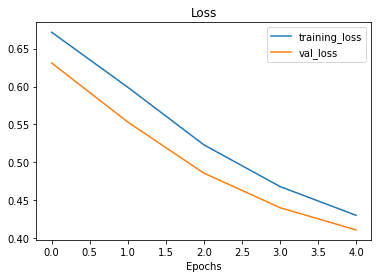

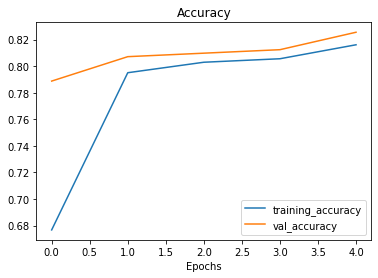

In [187]:
#from helper_functions import plot_loss_curves

#plot_loss_curves(model_7_history)

In [191]:
# Making a better dataset split (no data leakage)

train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]


train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent),len(train_sentences_10_percent)

(685, 685)

In [194]:
# Check the number of each label in the updated training data subset

pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [195]:
# Check the number of targets in our subset of data

train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [197]:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")]
)

model_7.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_7_history = model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "tf_hub_sentence_encoder_10_percent"
    )]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20220808-200226
Epoch 1/5
22/22 [==============================] - 4s 91ms/step - loss: 0.6737 - accuracy: 0.6584 - val_loss: 0.6508 - val_accuracy: 0.7178
Epoch 2/5
22/22 [==============================] - 1s 48ms/step - loss: 0.6044 - accuracy: 0.7869 - val_loss: 0.5979 - val_accuracy: 0.7493
Epoch 3/5
22/22 [==============================] - 1s 40ms/step - loss: 0.5287 - accuracy: 0.8117 - val_loss: 0.5422 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 1s 38ms/step - loss: 0.4666 - accuracy: 0.8190 - val_loss: 0.5069 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 38ms/step - loss: 0.4234 - accuracy: 0.8248 - val_loss: 0.4937 - val_accuracy: 0.7782


In [201]:
model_7_pred_prods = model_7.predict(val_sentences)
model_7_pred_prods

24/24 [==============================] - 1s 16ms/step


array([[0.22181405],
       [0.5880644 ],
       [0.8906073 ],
       [0.37894738],
       [0.5482235 ],
       [0.6881271 ],
       [0.8631701 ],
       [0.8033568 ],
       [0.8298558 ],
       [0.15552986],
       [0.49213162],
       [0.47934717],
       [0.29891327],
       [0.3175157 ],
       [0.48035315],
       [0.14860341],
       [0.2722888 ],
       [0.62267923],
       [0.5674558 ],
       [0.3413096 ],
       [0.5514228 ],
       [0.34919888],
       [0.29112342],
       [0.11106555],
       [0.49120924],
       [0.8242062 ],
       [0.23169601],
       [0.38229054],
       [0.11400156],
       [0.33148134],
       [0.607839  ],
       [0.78907055],
       [0.41184196],
       [0.30536878],
       [0.4930635 ],
       [0.1735495 ],
       [0.85635257],
       [0.09270827],
       [0.12418848],
       [0.87675685],
       [0.15715908],
       [0.2066139 ],
       [0.56567264],
       [0.43497708],
       [0.2533918 ],
       [0.78346664],
       [0.2718638 ],
       [0.881

In [202]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_prods))
model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [204]:
model_7_results = calculate_results(y_true=val_labels,y_pred=model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7804499491198106,
 'recall': 0.7782152230971129,
 'f1': 0.7760126933653841}

In [205]:
### Be very careful when creating training/val/test splits that you don't leak data across the,
#   datasets, otherwise your model evaluation metrics will be wrong. If something looks too good 
#   to be true (a model trained on 10% of data outperforming the same model trained on 100% data)
#   trust your gut and go back through to find where the error may lie.

In [211]:
# Comparing the performance of each of our models

# Combine model results into a DataFrame

all_model_results = pd.DataFrame({
    "baseline":baseline_results,
    "1_simple_dense":model_1_results,
    "2_lstm":model_2_results,
    "3_gru":model_3_results,
    "4_bidirectional":model_4_results,
    "5_conv1d":model_6_results,
    "6_tf_hub_use_encoder":model_6_results,
    "7_tf_hub_use_encoder_10_percent":model_7_results
    })
all_model_results = all_model_results.transpose()


In [212]:
# Reduce the accuracy to the same scale as other metrics

all_model_results["accuracy"] = all_model_results["accuracy"] / 100

In [213]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.794743,0.787402,0.783640
2_lstm,0.767717,0.770226,0.767717,0.765130
3_gru,0.776903,0.779882,0.776903,0.774350
4_bidirectional,0.755906,0.755729,0.755906,0.754782
5_conv1d,0.816273,0.818446,0.816273,0.814808
6_tf_hub_use_encoder,0.816273,0.818446,0.816273,0.814808
7_tf_hub_use_encoder_10_percent,0.778215,0.780450,0.778215,0.776013


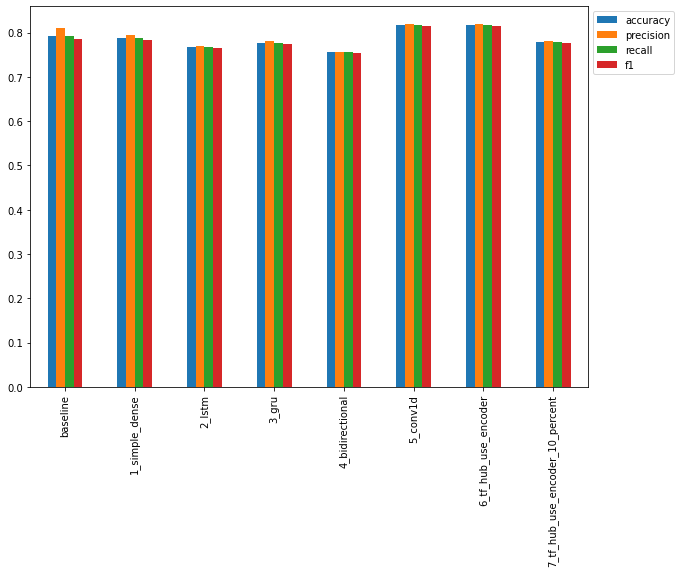

In [215]:
# Plot and compare all of the model results

all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<AxesSubplot:>

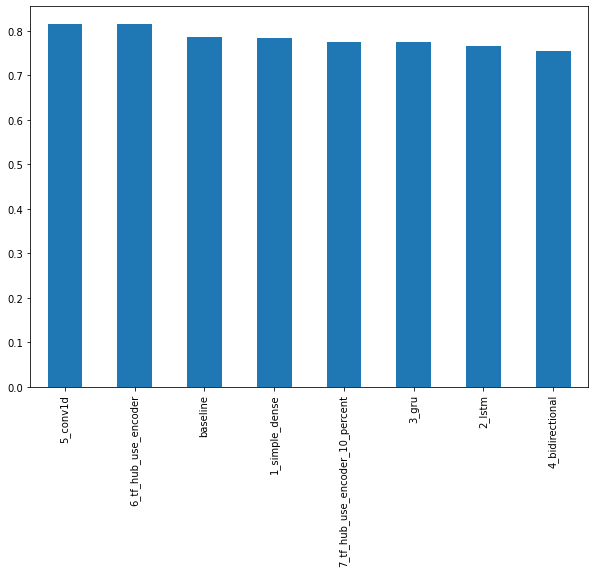

In [216]:
# Sort model results by f1-score

all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

In [217]:
# Uploading our model training logs to TensorBoard.dev

# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)

# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./model_logs/ \
    --one_shot

^C


In [218]:
# See the previous TensorBoard Dev experiments you've run

!tensorboard dev list

^C


In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:

# !tensorboard dev delete --experiment_id experiment_id

In [219]:
# Saving and loading a trained model

# There are two main formats to save a model to in TensorFlow:

# 1. The HDF5 format
# 2. The 'SavedModel' format (this is the default when using TensorFlow)

In [220]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [222]:
# Save TF Hub Sentence Encoder model to HDF5 format

model_6.save("model_6.h5")

In [225]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",custom_objects={"KerasLayer":hub.KerasLayer})

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

In [ ]:
# How does our loaded model perform

loaded_model_6.evaluate(val_sentences, val_labels)

In [227]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)

model_6.save("model_6_SavedModel_format")

ResourceExhaustedError: OOM when allocating tensor with shape[26667,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ReadVariableOp]

In [ ]:
SavedModel_loaded_model_6 = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
SavedModel_loaded_model_6.evaluate(val_sentences,val_labels)

In [228]:
### Finding the most wrong examples

# * If our best model still isn't perfect, what examples is it getting wrong
# * And of these wrong examples which ones is it getting *most* wrong (those will prediction
#   probabilities closest to the opposite class)

# For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999
# (really close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage

unzip_data("08_model_6_USE_feature_extractor.zip")

In [230]:
# Create DataFrame with validation sentences and best performing model predictions

# Import previously trained model from Google Storage

model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

In [231]:
# Make predictions with the loaded model from Google Storage

model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10] # these should be in label format

24/24 [==============================] - 1s 25ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [233]:
# Create DataFrame with validation sentences,validation labels and best performing model prediction labels + probabilities

val_df = pd.DataFrame({
    "text":val_sentences,
    "target":val_labels,
    "pred":model_6_preds,
    "pred_prob":tf.squeeze(model_6_pred_probs)})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.155934
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.740871
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986758
3,@camilacabello97 Internally and externally scr...,1,0.0,0.191330
4,Radiation emergency #preparedness starts with ...,1,1.0,0.771119


In [236]:
# Find the wrong predictions and sort by prediction probabilities

most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob",ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.931079
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.865880
759,FedEx will no longer transport bioterror patho...,0,1.0,0.860719
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.827728
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.823788
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.822217
628,@noah_anyname That's where the concentration c...,0,1.0,0.815620
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.791791
695,A look at state actions a year after Ferguson'...,0,1.0,0.778076
474,My phone looks like it was in a car ship airpl...,0,1.0,0.768571


In [237]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.040074
38,Why are you deluged with low self-image? Take ...,1,0.0,0.034439
233,I get to smoke my shit in peace,1,0.0,0.033025
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.032141
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.023705


In [ ]:
# Let's remind ourselves of the target labels..

# * 0 = not disaster
# * 1 = disaster

In [238]:
# Check the false positives (model predicted 1 when should've been 0)

for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")


Target: 0, Pred: 1.0, Prob: 0.9310788512229919
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8658801317214966
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1.0, Prob: 0.8607189059257507
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8277279138565063
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.823788046836853
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1.0, Prob: 0.8222169876098633
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should list

In [240]:
# Check the false negatives (model predicted 0 when should've been 1)

for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 1, Pred: 0.0, Prob: 0.051897916942834854
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0.0, Prob: 0.05083673447370529
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.048782456666231155
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.044237662106752396
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.043758321553468704
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04007368162274361
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding of

In [245]:
## Making predictions on the test dataset and visualizing them

test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_samples in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_samples])) #our model expect a list as input
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text: \n{test_samples}\n")
    print("----\n")

1/1 [==============================] - 0s 66ms/step
Pred: 1, Prob: 0.9413477778434753
Text: 
IRIN Asia | Red tape tangles Nepal reconstruction | Nepal | Disaster Risk Reduction | Natural Disasters http://t.co/q7LG6ncf7G

----

1/1 [==============================] - 0s 92ms/step
Pred: 1, Prob: 0.7520865797996521
Text: 
Green Line trains resume service after South Side derailment: Green Line service has resumed more than four h... http://t.co/dJztc7apf1

----

1/1 [==============================] - 0s 61ms/step
Pred: 1, Prob: 0.9608497023582458
Text: 
Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released: Harun Ìàekdar a member o... http://t.co/fMoqK26hIm

----

1/1 [==============================] - 0s 65ms/step
Pred: 1, Prob: 0.8183940052986145
Text: 
Concealed Carrier Rescues Hostage Captures Naked Attacker http://t.co/uLy5hM6PqR

----

1/1 [==============================] - 0s 156ms/step
Pred: 0, Prob: 0.05819382891058922
Text: 
I've spent the day  trau

In [246]:
## The speed/score tradeoff

# Let's make a function to measure the time of prediction

import time

def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
    """

    start_time = time.perf_counter() # get start time
    model.predict(samples)           # make predictions
    end_time = time.perf_counter()   # get finish time
    total_time = end_time-start_time # calculuate how long predictions took to make
    time_per_pred = total_time/len(samples)

    return total_time, time_per_pred

In [247]:
# Calculate TF Hub Sentence Encoder time per pred

model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6,val_sentences)

model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 34ms/step


(1.0972063000081107, 0.001439903280850539)

In [248]:
# Calculate our baseline model times per pred

baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0,val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.4874945000046864, 0.0006397565616859402)

In [249]:
model_6_results = calculate_results(y_true=val_labels,y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

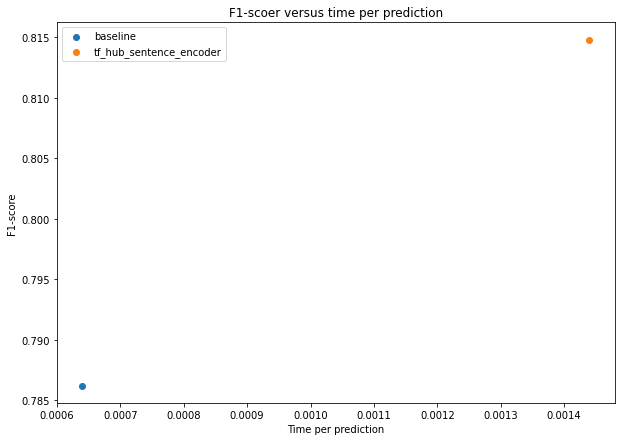

In [251]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"],label="baseline")
plt.scatter(model_6_time_per_pred,model_6_results["f1"],label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-scoer versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");